# Webscraping Naukri.com

## Problem Statement: 
Scrape through all the given 45 links, each representing different types of jobs. Each link will have thousands of jobs posted across multiple pages. The objective is tho scrape all these pages in each of the links and prepare a dataset of jobs. 

### NOTE:
This Python code will give a result that scrapes through all the links. But since each of the link has thousands of jobs posted, it would take immense time to scrape through all the webpages. So, as the purpose of this assigment is to test technical capabilities, the following adjustments are made:
1. In each link, only first 2 webpages are scraped. 
2. In each web page, only top 2 jobs are scraped. This is because, to scrape job description, each of the job post should be opened and it will take immense time for it. Instead, we can remove Job Description column to go for all the 20 per page.
3. Given a slow internet connection at my end, few of the webpages may fail to open even after giving a wait time. Those webpages may not be scrapped. 

In any case, the Python Code is scalable for all the web pages and all the job-posts. With faster internet connection and computer, this code will extract all the information available. 

In [1]:
# Loading required packages

import pandas as pd
import numpy as np
import math


# Packages for webscraping
import os, random, sys, time
from urllib.parse import urlparse
from selenium import webdriver
from bs4 import BeautifulSoup
import requests

In [2]:
job_postings = pd.read_csv("link_by_areas.csv")
job_postings.head()

,type,link
0,Accounting Jobs,https://www.naukri.com/accounting-jobs?xt=cats...
1,Interior Design Jobs,https://www.naukri.com/interior-design-jobs?xt...
2,Bank Jobs,https://www.naukri.com/bank-jobs?xt=catsrch&qf...
3,Content Writing Jobs,https://www.naukri.com/content-writing-jobs?xt...
4,Consultant Jobs,https://www.naukri.com/consultant-jobs?xt=cats...


In [3]:
job_postings.shape

(45, 2)

In [4]:
# Opening ChromeDriver for webscraping. 
browser = webdriver.Chrome('chromedriver.exe')
driver =webdriver.Chrome('chromedriver.exe')

We'll now write the following functions and then assemble them together:

1. **all_jobs_on_page:** This function will extract all the job postings on a given webpage. We will later choose only top 2 from these postings for computing purposes. 

2. **get_details:** This function will extract all the required details about a job from a job posting and append it to the dataframe. 

In [5]:
def all_jobs_on_page(webpage,class_):
    browser.get(webpage)
    browser.implicitly_wait(7)
    return browser.find_elements_by_class_name(class_)

In [6]:
def get_details(all_jobs,df,domain):
    
    for job in all_jobs:
        result_html = job.get_attribute('innerHTML')
        soup = BeautifulSoup(result_html,"html.parser")
        
        try:
            title = soup.find("a", class_ = "title")
            title = title.get_text()
        except:
            title = "None"
        
        try:
            subTitle = soup.find("a", class_ = "subTitle")
            subTitle = subTitle.get_text()
        except:
            subTitle = "None"
        
        try: 
            experience = soup.find("span", class_ = "ellipsis")
            experience = experience.get_text()
        except:
            experience = "None"
        
        try: 
            salary = soup.find("li", class_ = "salary")
            salary = salary.get_text()
        except:
            salary = "None"
        
        try: 
            location = soup.find("li", class_ = "location")
            location = location.get_text()
        except:
            location = "None"

        try: 
            post_date = soup.find("div", class_ = "grey")
            post_date = post_date.get_text()
        except:
            post_date = "Today"
        
        try: 
            job_tags = soup.find_all("li", class_ = "lh16")
            job_tags = [tag.get_text() for tag in job_tags]
        except:
            job_tags = "None"
        
        try:
            hrefs = soup.find("a", href=True)['href']
            driver.get(hrefs)
            driver.implicitly_wait(5)
            job_description = driver.find_element_by_class_name("dang-inner-html").text.replace("\n",'')
        
        except:
            hrefs = "None"
            job_description = "None"
            
        job_domain = domain
        
        
        df = df.append({'Job_Title':title, "Company":subTitle, "Experience":experience,
                    'Salary':salary, "Location":location, "Posting Date":post_date,
                   "Tags":job_tags, "Link":hrefs, "Description":job_description,
                       "Job Domain":job_domain},ignore_index=True)
        
    return df
     

In [7]:
empty_df = pd.DataFrame(columns=["Job_Title","Company","Experience","Salary","Location","Job Domain","Description","Tags","Posting Date","Scraping Date","Link"])
JOBS_DF = pd.DataFrame(columns=["Job_Title","Company","Experience","Salary","Location","Job Domain","Description","Tags","Posting Date","Scraping Date","Link"])

Now, we'll use the above functions to do the webscraping. The following is the methodology:
1. Select the first link from the job_postings data provided. 
2. Find out the maximum number of webpages present in this link. This is done by dividing the total number of job postings by 20. {There are 20 job postings per webpage}
3. Make a list of all webpage links. 
4. Loop across the webpage links: (Due to computing limitations, only the first 2 web pages have been selected)
    a.) Use the function "all_jobs_on_page" to get all the 20 jobs posted on the page. (Due to computing limitations, only first two job postings have been selected)
    b.) Use the function "get_details" to get all the job details from the jobs posted. 
    
5. Select next link from job_postings data and go back to step 2. 

In [8]:
for idx in job_postings.index:
    link = job_postings["link"][idx]
    browser.get(link)
    browser.implicitly_wait(10)
    print("\n")
    print("Getting details of Job Type:", job_postings["type"][idx])
    print("\n")
    
    #Finding maximum number of pages
    try:
        p = browser.find_element_by_class_name("mr-5").text
        print(p)
        print("\n")
        max_pages = math.ceil(int(p.split()[-1])/20) # since 20 jobs per page.
        print("Number of webpages:",max_pages)
        print("\n")
    except:
        pass
    
    #Since only 20 jobs are per page, there are multiple pages in every link. We'll list them.  
    pages = []
    for i in range(1, max_pages+1):
        page = link.split('?')[0]+"-"+str(i)+"?"+link.split('?')[1]
        pages.append(page)
    
    
    for page in pages[:2]: #Selecting only 2 webpages for computational purposes. 
        try:
            all_jobs = all_jobs_on_page(page, "jobTuple")
            print("Got all jobs from Page", page)
            all_jobs = all_jobs[:2] #Selecting only top 2 jobs from each page
            resultt = get_details(all_jobs,empty_df,job_postings["type"][idx])
            print("Got all details and appended")
        except:
            pass
    
    
        JOBS_DF = JOBS_DF.append(resultt,ignore_index=True)
    print("\n")



Getting details of Job Type: Accounting Jobs


1 - 20 of 16146


Number of webpages: 808


Got all jobs from Page https://www.naukri.com/accounting-jobs-1?xt=catsrch&qf[]=1
Got all details and appended
Got all jobs from Page https://www.naukri.com/accounting-jobs-2?xt=catsrch&qf[]=1
Got all details and appended




Getting details of Job Type: Interior Design Jobs


1 - 20 of 1925


Number of webpages: 97


Got all jobs from Page https://www.naukri.com/interior-design-jobs-1?xt=catsrch&qf[]=2
Got all details and appended
Got all jobs from Page https://www.naukri.com/interior-design-jobs-2?xt=catsrch&qf[]=2
Got all details and appended




Getting details of Job Type: Bank Jobs


1 - 20 of 7193


Number of webpages: 360


Got all jobs from Page https://www.naukri.com/bank-jobs-1?xt=catsrch&qf[]=6
Got all details and appended
Got all jobs from Page https://www.naukri.com/bank-jobs-2?xt=catsrch&qf[]=6
Got all details and appended




Getting details of Job Type: Content Writing Jobs


1

Got all jobs from Page https://www.naukri.com/telecom-software-jobs-2?xt=catsrch&qf[]=24.10
Got all details and appended




Getting details of Job Type: Telecom Jobs


1 - 20 of 2558


Number of webpages: 128


Got all jobs from Page https://www.naukri.com/telecom-jobs-1?xt=catsrch&qf[]=37
Got all details and appended
Got all jobs from Page https://www.naukri.com/telecom-jobs-2?xt=catsrch&qf[]=37
Got all details and appended




Getting details of Job Type: BPO Jobs


1 - 20 of 39354


Number of webpages: 1968


Got all jobs from Page https://www.naukri.com/bpo-jobs-1?xt=catsrch&qf[]=8
Got all details and appended
Got all jobs from Page https://www.naukri.com/bpo-jobs-2?xt=catsrch&qf[]=8
Got all details and appended




Getting details of Job Type: Legal Jobs


1 - 20 of 1308


Number of webpages: 66


Got all jobs from Page https://www.naukri.com/legal-jobs-1?xt=catsrch&qf[]=13
Got all details and appended
Got all jobs from Page https://www.naukri.com/legal-jobs-2?xt=catsrch&qf[]=13


In [9]:
JOBS_DF.drop_duplicates(subset=["Job_Title","Company","Experience","Salary","Location","Link"],keep=False,inplace=True)

In [10]:
JOBS_DF

,Job_Title,Company,Experience,Salary,Location,Job Domain,Description,Tags,Posting Date,Scraping Date,Link
0,"Accounts Executive,",Visakh Homes Limited,0-2 Yrs,"2,00,000 - 2,50,000 PA.",Chennai,Accounting Jobs,Job role: He/she should be responsible for :pa...,"[Tally, accounts executive, accountant, Accoun...",16 Days Ago,NaN,https://www.naukri.com/job-listings-accounts-e...
1,ICWA - Inter,Aurobindo Pharma Ltd,2-7 Yrs,Not disclosed,Hyderabad,Accounting Jobs,"Accounting of costs, accrual for various types...","[revenue recognition, intercompany, icwa inter...",7 Days Ago,NaN,https://www.naukri.com/job-listings-icwa-inter...
2,WNS || Gurgaon - Hiring For Cost Accounting As...,WNS GLOBAL SERVICES PRIVATE LIMITED,0-2 Yrs,"2,00,000 - 2,50,000 PA.",Gurgaon,Accounting Jobs,None,"[MCOM, Bcom, Cost Accounting, Accounting Entri...",8 Days Ago,NaN,None
3,Chartered Accountant,International Tractors Limited,0-4 Yrs,"2,00,000 - 4,00,000 PA.",Hoshiarpur,Accounting Jobs,None,"[chartered accountant, balance sheet, accounti...",Today,NaN,None
4,Architect Interior Designer,Milestone consultants.,0-3 Yrs,Not disclosed,Bengaluru(Shanti Nagar),Interior Design Jobs,Required Architects/Interior Designers with a ...,"[interior designing, design, architect, interi...",10 Days Ago,NaN,https://www.naukri.com/job-listings-architect-...
...,...,...,...,...,...,...,...,...,...,...,...
171,Deck Cadet-Ro Ro Cargo & Container Ship,ocean star ships,2-6 Yrs,Not disclosed,Dehradun,Shipping Jobs,Deck Cadet required for Ro Ro Cargo & Containe...,[Deck Cadet-Ro Ro Cargo & Container Ship],30+ Days Ago,NaN,https://www.naukri.com/job-listings-deck-cadet...
172,Power BI Report Developer - Business Analyst,FitnessBI,3-8 Yrs,Not disclosed,"Navi Mumbai, Mumbai(LBS Marg +1)",Business Intelligence Jobs,Business Analyst and Power BI Report Developer...,"[SSMS, Microsoft Technologies, Business Intell...",7 Days Ago,NaN,https://www.naukri.com/job-listings-power-bi-r...
173,Opportunity For a Business Intelligence Analys...,TE Connectivity India Private Limited,6-10 Yrs,"7,50,000 - 14,00,000 PA.",Bengaluru,Business Intelligence Jobs,ROLE OBJECTIVE6-10 years of relevant work expe...,"[Business Intelligence, Design Analysis, Sales...",Today,NaN,https://www.naukri.com/job-listings-opportunit...
174,Udaan | Hiring For Lead Business Intelligence ...,HIVELOOP TECHNOLOGY PRIVATE LIMITED,6-10 Yrs,Not disclosed,Mumbai,Business Intelligence Jobs,ABOUT THE ROLE:Job Purpose:The Business Intell...,"[staples, Spotfire, R, SAS, Tableau, QlikView,...",30+ Days Ago,NaN,https://www.naukri.com/job-listings-udaan-hiri...


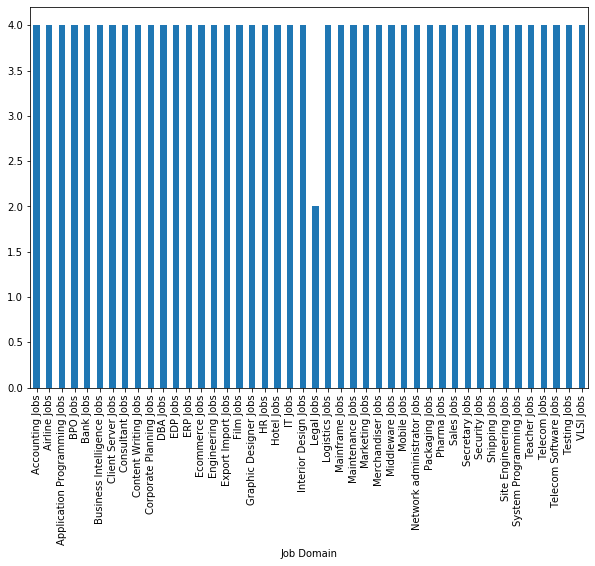

In [15]:
import matplotlib.pyplot as plt
JOBS_DF.groupby("Job Domain")["Company"].count().plot(kind="bar", figsize=(10,7))
plt.show()

In the domain where only 2 jobs were recorded, it is because of slow internet on my end. One of the two links didn't load quickly despite giving a waiting time. The code has thus skipped those websites. With faster internet connection or increased wait time, such issues can be addressed. 

In [37]:
JOBS_DF_copy = JOBS_DF.copy()
#JOBS_DF.to_csv("WebScraping_Naukri_testresults.csv")

In [38]:
from datetime import date, timedelta
JOBS_DF_copy["Scraping Date"] = date.today()

In [39]:
#Converting "X days ago" to Date format.
for idx in JOBS_DF_copy.index:
    try:
        JOBS_DF_copy["Posting Date"][idx] = JOBS_DF_copy["Scraping Date"][idx] - timedelta(days = int(JOBS_DF_copy["Posting Date"][idx][:2]))
    except:
        JOBS_DF_copy["Posting Date"][idx] = JOBS_DF_copy["Scraping Date"][idx]

In [40]:
JOBS_DF_copy

,Job_Title,Company,Experience,Salary,Location,Job Domain,Description,Tags,Posting Date,Scraping Date,Link
0,"Accounts Executive,",Visakh Homes Limited,0-2 Yrs,"2,00,000 - 2,50,000 PA.",Chennai,Accounting Jobs,Job role: He/she should be responsible for :pa...,"[Tally, accounts executive, accountant, Accoun...",2020-06-09,2020-06-25,https://www.naukri.com/job-listings-accounts-e...
1,ICWA - Inter,Aurobindo Pharma Ltd,2-7 Yrs,Not disclosed,Hyderabad,Accounting Jobs,"Accounting of costs, accrual for various types...","[revenue recognition, intercompany, icwa inter...",2020-06-18,2020-06-25,https://www.naukri.com/job-listings-icwa-inter...
2,WNS || Gurgaon - Hiring For Cost Accounting As...,WNS GLOBAL SERVICES PRIVATE LIMITED,0-2 Yrs,"2,00,000 - 2,50,000 PA.",Gurgaon,Accounting Jobs,None,"[MCOM, Bcom, Cost Accounting, Accounting Entri...",2020-06-17,2020-06-25,None
3,Chartered Accountant,International Tractors Limited,0-4 Yrs,"2,00,000 - 4,00,000 PA.",Hoshiarpur,Accounting Jobs,None,"[chartered accountant, balance sheet, accounti...",2020-06-25,2020-06-25,None
4,Architect Interior Designer,Milestone consultants.,0-3 Yrs,Not disclosed,Bengaluru(Shanti Nagar),Interior Design Jobs,Required Architects/Interior Designers with a ...,"[interior designing, design, architect, interi...",2020-06-15,2020-06-25,https://www.naukri.com/job-listings-architect-...
...,...,...,...,...,...,...,...,...,...,...,...
171,Deck Cadet-Ro Ro Cargo & Container Ship,ocean star ships,2-6 Yrs,Not disclosed,Dehradun,Shipping Jobs,Deck Cadet required for Ro Ro Cargo & Containe...,[Deck Cadet-Ro Ro Cargo & Container Ship],2020-05-26,2020-06-25,https://www.naukri.com/job-listings-deck-cadet...
172,Power BI Report Developer - Business Analyst,FitnessBI,3-8 Yrs,Not disclosed,"Navi Mumbai, Mumbai(LBS Marg +1)",Business Intelligence Jobs,Business Analyst and Power BI Report Developer...,"[SSMS, Microsoft Technologies, Business Intell...",2020-06-18,2020-06-25,https://www.naukri.com/job-listings-power-bi-r...
173,Opportunity For a Business Intelligence Analys...,TE Connectivity India Private Limited,6-10 Yrs,"7,50,000 - 14,00,000 PA.",Bengaluru,Business Intelligence Jobs,ROLE OBJECTIVE6-10 years of relevant work expe...,"[Business Intelligence, Design Analysis, Sales...",2020-06-25,2020-06-25,https://www.naukri.com/job-listings-opportunit...
174,Udaan | Hiring For Lead Business Intelligence ...,HIVELOOP TECHNOLOGY PRIVATE LIMITED,6-10 Yrs,Not disclosed,Mumbai,Business Intelligence Jobs,ABOUT THE ROLE:Job Purpose:The Business Intell...,"[staples, Spotfire, R, SAS, Tableau, QlikView,...",2020-05-26,2020-06-25,https://www.naukri.com/job-listings-udaan-hiri...


In [41]:
JOBS_DF_copy.to_csv("WebScraping_NaukriJobs.csv")